# 📊 Model Answer Analysis Dashboard

This notebook helps you analyze the detailed JSON results from your Optuna optimization pipeline.

**Key Questions We Can Answer:**
- Where does steering help but baseline fails?
- Where does baseline work but steering breaks it?
- What types of questions benefit most from steering?
- How do answer qualities compare between models?

In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define get_pattern function (used across multiple sections)
def get_pattern(row):
    """Get performance pattern for a row."""
    baseline = row['is_baseline_correct']
    steered = row['is_correct']
    
    if baseline and steered:
        return "Both Correct ✅✅"
    elif not baseline and not steered:
        return "Both Wrong ❌❌"
    elif not baseline and steered:
        return "Steering Helps 🎯✅"  # This is what you want!
    else:  # baseline and not steered
        return "Steering Hurts ✅❌"

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


## 1. 📁 Load Your JSON Results

First, let's find and load your JSON files. Update the paths below to point to your actual result files.

In [17]:
# 🔧 Configure these paths to your actual files  
# Default paths - change these to your actual directories
BASE_DIR = Path("/workspace/wisent-guard/outputs/optuna_minimal_example")  # Absolute path
# Or use relative if running from project root: Path("outputs/optuna_minimal_example")

# Find all run directories (new timestamped structure)
run_dirs = sorted([d for d in BASE_DIR.glob("run_*") if d.is_dir()])
print(f"Found {len(run_dirs)} optimization runs")

if run_dirs:
    # Use the latest run by default
    RESULTS_DIR = run_dirs[-1]
    print(f"📁 Using latest run: {RESULTS_DIR.name}")
    
    # Find files in the latest run
    validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
    test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))
    
    print(f"   - {len(validation_files)} validation files")
    print(f"   - {len(test_files)} test files") 
    
    if validation_files:
        print(f"   - Latest validation: {validation_files[-1].name}")
    if test_files:
        print(f"   - Latest test: {test_files[-1].name}")
        
    # 📊 Show all available runs for reference
    print(f"\n📋 All available runs:")
    for run_dir in run_dirs:
        val_count = len(list(run_dir.glob("validation_detailed_results_*.json")))
        test_count = len(list(run_dir.glob("test_detailed_results_*.json")))
        print(f"   - {run_dir.name}: {val_count} validation, {test_count} test files")
        
else:
    # Fallback to old flat structure
    RESULTS_DIR = BASE_DIR
    validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
    test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))
    print(f"📁 Using flat structure: {len(validation_files)} validation, {len(test_files)} test files")

# 🔧 Or manually specify a specific run:
# RESULTS_DIR = BASE_DIR / "run_20250730_143000"  # Specific run directory
# validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
# test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))

Found 1 optimization runs
📁 Using latest run: run_20250730_145812
   - 6 validation files
   - 1 test files
   - Latest validation: validation_detailed_results_trial_000_20250730_145948.json
   - Latest test: test_detailed_results_20250730_150054.json

📋 All available runs:
   - run_20250730_145812: 6 validation, 1 test files


In [18]:
# Load test results (most important for comparison)
if test_files:
    with open(test_files[-1], 'r') as f:
        test_data = json.load(f)
    
    test_df = pd.DataFrame(test_data)
    print(f"✅ Loaded test data: {len(test_df)} samples")
    print(f"Columns: {list(test_df.columns)}")
else:
    print("❌ No test files found. Run your optimization first!")
    test_df = None

✅ Loaded test data: 50 samples
Columns: ['row', 'question', 'correct_answer', 'baseline_model_answer', 'model_answer', 'is_baseline_correct', 'is_correct']


In [19]:
# Load validation results (optional - for trial analysis)
if validation_files:
    # Load the latest validation file
    with open(validation_files[-1], 'r') as f:
        val_data = json.load(f)
    
    val_df = pd.DataFrame(val_data)
    print(f"✅ Loaded validation data: {len(val_df)} samples")
    
    # Or load multiple validation files to compare trials
    all_val_data = []
    for i, file in enumerate(validation_files[-5:]):  # Last 5 trials
        with open(file, 'r') as f:
            data = json.load(f)
        for item in data:
            item['trial'] = i
            item['filename'] = file.name
        all_val_data.extend(data)
    
    all_val_df = pd.DataFrame(all_val_data)
    print(f"✅ Loaded multi-trial validation data: {len(all_val_df)} samples across {len(validation_files[-5:])} trials")
else:
    print("❌ No validation files found")
    val_df = None
    all_val_df = None

✅ Loaded validation data: 20 samples
✅ Loaded multi-trial validation data: 100 samples across 5 trials


## 2. 🔍 Quick Data Overview

In [20]:
if test_df is not None:
    print("📊 TEST RESULTS SUMMARY")
    print("=" * 50)
    
    # Basic stats
    baseline_correct = test_df['is_baseline_correct'].sum()
    steered_correct = test_df['is_correct'].sum()
    total = len(test_df)
    
    print(f"Total questions: {total}")
    print(f"Baseline correct: {baseline_correct}/{total} ({baseline_correct/total*100:.1f}%)")
    print(f"Steered correct: {steered_correct}/{total} ({steered_correct/total*100:.1f}%)")
    print(f"Improvement: {steered_correct - baseline_correct:+d} questions ({(steered_correct - baseline_correct)/total*100:+.1f}%)")
    
    # Show first few rows
    print("\n📋 First 3 samples:")
    display(test_df[['row', 'question', 'is_baseline_correct', 'is_correct']].head(3))

📊 TEST RESULTS SUMMARY
Total questions: 50
Baseline correct: 7/50 (14.0%)
Steered correct: 7/50 (14.0%)
Improvement: +0 questions (+0.0%)

📋 First 3 samples:


,row,question,is_baseline_correct,is_correct
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,False,False
1,1,A robe takes 2 bolts of blue fiber and half th...,False,False
2,2,Josh decides to try flipping a house. He buys...,False,False


## 3. 🎯 Key Analysis: Where Does Steering Help?

This is your main question - let's find cases where steering works but baseline fails!

🔍 PERFORMANCE PATTERNS
Both Wrong ❌❌: 41 questions (82.0%)
Both Correct ✅✅: 5 questions (10.0%)
Steering Helps 🎯✅: 2 questions (4.0%)
Steering Hurts ✅❌: 2 questions (4.0%)


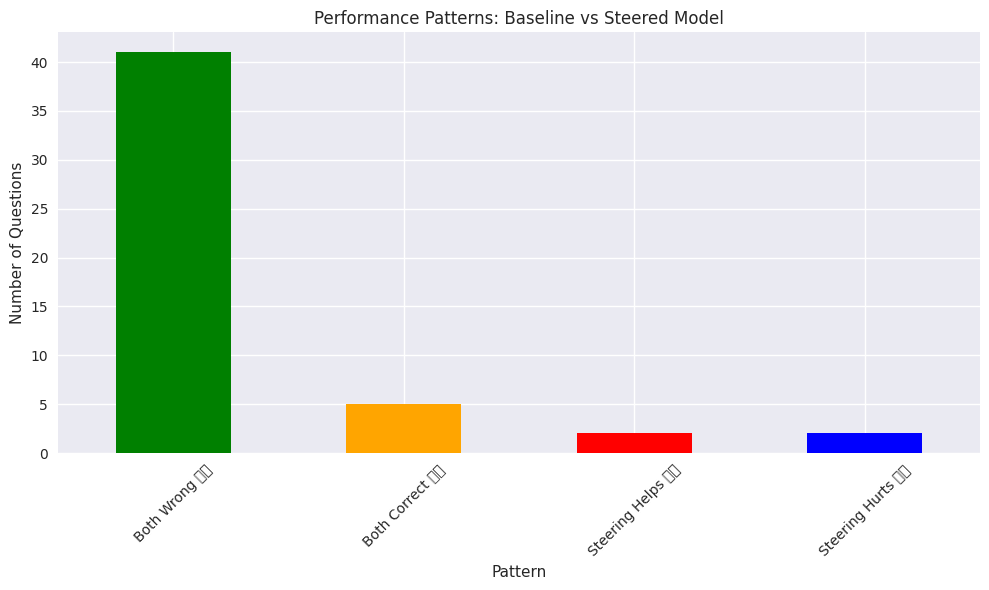

In [21]:
if test_df is not None:
    # Apply performance pattern categories
    test_df['pattern'] = test_df.apply(get_pattern, axis=1)
    
    # Count patterns
    pattern_counts = test_df['pattern'].value_counts()
    print("🔍 PERFORMANCE PATTERNS")
    print("=" * 50)
    for pattern, count in pattern_counts.items():
        percentage = count / len(test_df) * 100
        print(f"{pattern}: {count} questions ({percentage:.1f}%)")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    pattern_counts.plot(kind='bar', color=['green', 'orange', 'red', 'blue'])
    plt.title('Performance Patterns: Baseline vs Steered Model')
    plt.xlabel('Pattern')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 4. 🎯 Deep Dive: Cases Where Steering Helps

Let's examine the specific questions where steering works but baseline fails!

In [22]:
if test_df is not None:
    # Filter for cases where steering helps
    steering_helps = test_df[test_df['pattern'] == 'Steering Helps 🎯✅'].copy()
    
    print(f"🎯 FOUND {len(steering_helps)} CASES WHERE STEERING HELPS!")
    print("=" * 60)
    
    if len(steering_helps) > 0:
        for idx, row in steering_helps.iterrows():
            print(f"\n📝 Question {row['row']}:")
            print(f"❓ {row['question'][:100]}..." if len(row['question']) > 100 else f"❓ {row['question']}")
            print(f"✅ Correct Answer: {row['correct_answer']}")
            print(f"❌ Baseline Answer: {row['baseline_model_answer'][:80]}..." if len(str(row['baseline_model_answer'])) > 80 else f"❌ Baseline Answer: {row['baseline_model_answer']}")
            print(f"✅ Steered Answer: {row['model_answer'][:80]}..." if len(str(row['model_answer'])) > 80 else f"✅ Steered Answer: {row['model_answer']}")
            print("-" * 60)
    else:
        print("😔 No cases found where steering helps. This might indicate:")
        print("   - Steering parameters need tuning")
        print("   - The model is already well-tuned for this task")
        print("   - Different steering methods might work better")

🎯 FOUND 2 CASES WHERE STEERING HELPS!

📝 Question 4:
❓ Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, containing seeds, meal...
✅ Correct Answer: 20
❌ Baseline Answer: Wendi needs to give her chickens a total of 150 cups of feed in the day.

#### 1...
✅ Steered Answer: Wendi has 20 chickens in her flock.
She has 20 chickens in her flock.
She has 20...
------------------------------------------------------------

📝 Question 26:
❓ Mishka bought 3 pairs of shorts, 3 pairs of pants, and 3 pairs of shoes. One pair of shorts costs $1...
✅ Correct Answer: 243
❌ Baseline Answer: Mishka bought 3 × $16.50 = $49.50 worth of shorts.
Mishka bought 3 × $22.50 = $6...
✅ Steered Answer: Mishka bought 3 x 16.50 = $49.50 worth of shorts.
Mishka bought 3 x 22.50 = $67....
------------------------------------------------------------


## 5. ⚠️ Cases Where Steering Hurts

Let's also examine where steering breaks previously correct answers.

In [23]:
if test_df is not None:
    # Filter for cases where steering hurts
    steering_hurts = test_df[test_df['pattern'] == 'Steering Hurts ✅❌'].copy()
    
    print(f"⚠️ FOUND {len(steering_hurts)} CASES WHERE STEERING HURTS")
    print("=" * 60)
    
    if len(steering_hurts) > 0:
        for idx, row in steering_hurts.iterrows():
            print(f"\n📝 Question {row['row']}:")
            print(f"❓ {row['question'][:100]}..." if len(row['question']) > 100 else f"❓ {row['question']}")
            print(f"✅ Correct Answer: {row['correct_answer']}")
            print(f"✅ Baseline Answer: {row['baseline_model_answer'][:80]}..." if len(str(row['baseline_model_answer'])) > 80 else f"✅ Baseline Answer: {row['baseline_model_answer']}")
            print(f"❌ Steered Answer: {row['model_answer'][:80]}..." if len(str(row['model_answer'])) > 80 else f"❌ Steered Answer: {row['model_answer']}")
            print("-" * 60)
    else:
        print("😊 Great! Steering doesn't break any previously correct answers.")

⚠️ FOUND 2 CASES WHERE STEERING HURTS

📝 Question 7:
❓ Carla is downloading a 200 GB file. Normally she can download 2 GB/minute, but 40% of the way throug...
✅ Correct Answer: 160
✅ Baseline Answer: 1. 200 GB / 2 GB/minute = 100 minutes
2. 100 minutes - 20 minutes = 80 minutes
3...
❌ Steered Answer: 1. Carla starts downloading the file and it takes 10 minutes to get 200 GB.
2. A...
------------------------------------------------------------

📝 Question 20:
❓ I have 10 liters of orange drink that are two-thirds water and I wish to add it to 15 liters of pine...
✅ Correct Answer: 15
✅ Baseline Answer: A. 18 liters
B. 19 liters
C. 20 liters
D. 21 liters
E. 22 liters

The correct an...
❌ Steered Answer: A. 18 liters
B. 19 liters
C. 20 liters
D. 21 liters
E. 22 liters

The correct an...
------------------------------------------------------------


## 6. 📊 Answer Quality Analysis

Let's analyze the quality and patterns in the answers themselves.

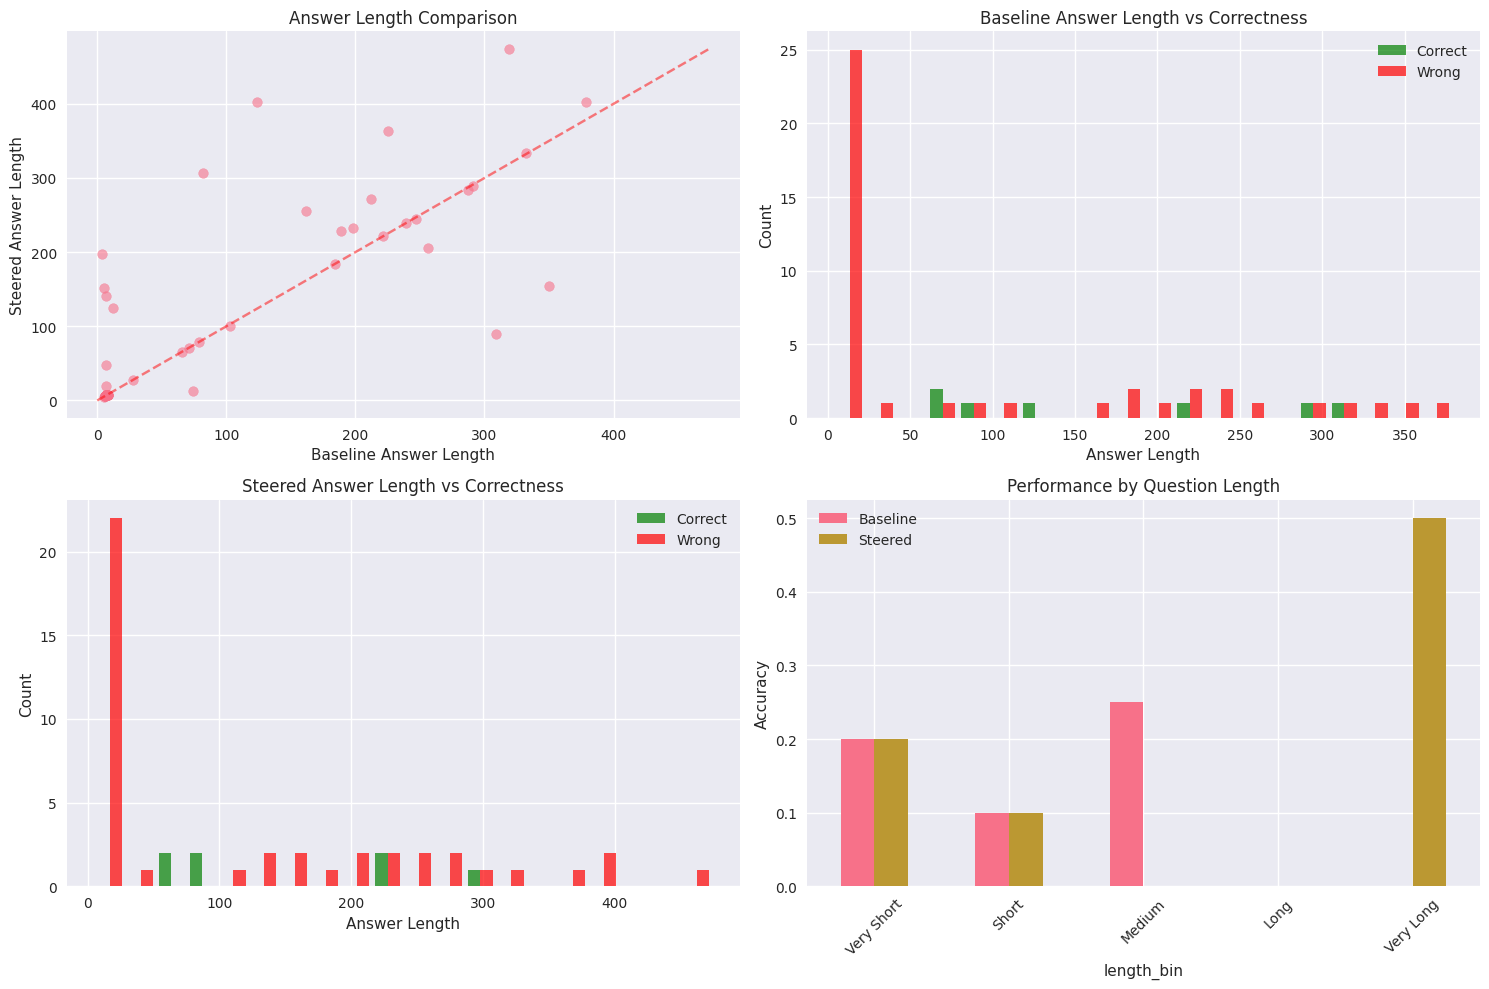


📊 ANSWER STATISTICS:
Average baseline answer length: 104.0 chars
Average steered answer length: 127.1 chars
Average question length: 231.2 chars


In [24]:
if test_df is not None:
    # Analyze answer lengths
    test_df['baseline_length'] = test_df['baseline_model_answer'].astype(str).str.len()
    test_df['steered_length'] = test_df['model_answer'].astype(str).str.len()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Length comparison
    axes[0,0].scatter(test_df['baseline_length'], test_df['steered_length'], alpha=0.6)
    axes[0,0].plot([0, test_df[['baseline_length', 'steered_length']].max().max()], 
                   [0, test_df[['baseline_length', 'steered_length']].max().max()], 'r--', alpha=0.5)
    axes[0,0].set_xlabel('Baseline Answer Length')
    axes[0,0].set_ylabel('Steered Answer Length')
    axes[0,0].set_title('Answer Length Comparison')
    
    # Length distribution by correctness
    correct_baseline = test_df[test_df['is_baseline_correct']]['baseline_length']
    wrong_baseline = test_df[~test_df['is_baseline_correct']]['baseline_length']
    
    axes[0,1].hist([correct_baseline, wrong_baseline], bins=20, alpha=0.7, 
                   label=['Correct', 'Wrong'], color=['green', 'red'])
    axes[0,1].set_xlabel('Answer Length')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Baseline Answer Length vs Correctness')
    axes[0,1].legend()
    
    # Same for steered
    correct_steered = test_df[test_df['is_correct']]['steered_length']
    wrong_steered = test_df[~test_df['is_correct']]['steered_length']
    
    axes[1,0].hist([correct_steered, wrong_steered], bins=20, alpha=0.7, 
                   label=['Correct', 'Wrong'], color=['green', 'red'])
    axes[1,0].set_xlabel('Answer Length')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Steered Answer Length vs Correctness')
    axes[1,0].legend()
    
    # Performance by question length
    test_df['question_length'] = test_df['question'].str.len()
    test_df['length_bin'] = pd.cut(test_df['question_length'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
    
    length_perf = test_df.groupby('length_bin')[['is_baseline_correct', 'is_correct']].mean()
    length_perf.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Performance by Question Length')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(['Baseline', 'Steered'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 ANSWER STATISTICS:")
    print(f"Average baseline answer length: {test_df['baseline_length'].mean():.1f} chars")
    print(f"Average steered answer length: {test_df['steered_length'].mean():.1f} chars")
    print(f"Average question length: {test_df['question_length'].mean():.1f} chars")

## 7. 🔍 Validation Analysis (Optional)

If you loaded validation data, let's see how performance varies across trials.

📈 VALIDATION PERFORMANCE ACROSS TRIALS


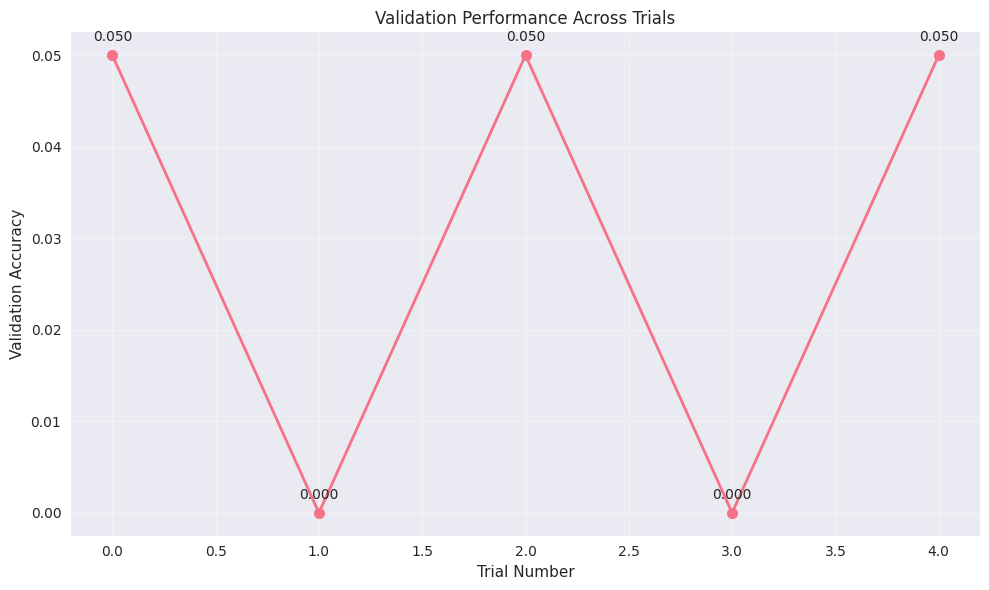


📊 Trial Performance Summary:
Trial 0.0: 0.050 accuracy (20.0 samples)
Trial 1.0: 0.000 accuracy (20.0 samples)
Trial 2.0: 0.050 accuracy (20.0 samples)
Trial 3.0: 0.000 accuracy (20.0 samples)
Trial 4.0: 0.050 accuracy (20.0 samples)


In [25]:
if all_val_df is not None and len(all_val_df) > 0:
    print("📈 VALIDATION PERFORMANCE ACROSS TRIALS")
    print("=" * 50)
    
    # Performance by trial
    trial_perf = all_val_df.groupby('trial')['is_correct'].agg(['mean', 'count']).reset_index()
    trial_perf.columns = ['trial', 'accuracy', 'count']
    
    plt.figure(figsize=(10, 6))
    plt.plot(trial_perf['trial'], trial_perf['accuracy'], 'o-', linewidth=2, markersize=8)
    plt.xlabel('Trial Number')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Performance Across Trials')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for idx, row in trial_perf.iterrows():
        plt.annotate(f'{row["accuracy"]:.3f}', 
                    (row['trial'], row['accuracy']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Trial Performance Summary:")
    for idx, row in trial_perf.iterrows():
        print(f"Trial {row['trial']}: {row['accuracy']:.3f} accuracy ({row['count']} samples)")
else:
    print("📝 No validation data loaded for trial analysis.")

## 8. 🛠️ Custom Analysis Functions

Here are some helper functions you can use for your own analysis:

In [26]:
def find_questions_by_pattern(df, pattern):
    """Find questions matching a specific performance pattern."""
    return df[df['pattern'] == pattern].copy()

def analyze_answer_keywords(df, column='model_answer'):
    """Analyze common keywords in answers."""
    all_text = ' '.join(df[column].astype(str).str.lower())
    words = all_text.split()
    word_freq = Counter(words)
    return word_freq.most_common(20)

def compare_answers_side_by_side(df, question_idx):
    """Compare baseline vs steered answers for a specific question."""
    row = df.iloc[question_idx]
    
    print(f"📝 Question {row['row']}:")
    print(f"❓ {row['question']}")
    print(f"✅ Correct: {row['correct_answer']}")
    print("\n🔵 BASELINE:")
    print(f"   {row['baseline_model_answer']}")
    print(f"   Correct: {row['is_baseline_correct']}")
    print("\n🟢 STEERED:")
    print(f"   {row['model_answer']}")
    print(f"   Correct: {row['is_correct']}")
    print(f"\n📊 Pattern: {row['pattern']}")

def export_patterns_to_csv(df, filename='analysis_results.csv'):
    """Export your analysis results to CSV for further examination."""
    df.to_csv(filename, index=False)
    print(f"✅ Results exported to {filename}")

print("🛠️ Helper functions defined:")
print("   - find_questions_by_pattern(df, pattern)")
print("   - analyze_answer_keywords(df, column)")
print("   - compare_answers_side_by_side(df, question_idx)")
print("   - export_patterns_to_csv(df, filename)")

🛠️ Helper functions defined:
   - find_questions_by_pattern(df, pattern)
   - analyze_answer_keywords(df, column)
   - compare_answers_side_by_side(df, question_idx)
   - export_patterns_to_csv(df, filename)


## 9. 🎮 Interactive Exploration

Use these cells for your own exploration!

In [27]:
# Example: Find all cases where steering helps
if test_df is not None:
    steering_wins = find_questions_by_pattern(test_df, 'Steering Helps 🎯✅')
    print(f"Found {len(steering_wins)} cases where steering helps")
    
    # Uncomment to see details:
    # for idx in range(min(3, len(steering_wins))):
    #     compare_answers_side_by_side(steering_wins, idx)
    #     print("="*80)

Found 2 cases where steering helps


In [28]:
# Example: Analyze keywords in correct vs incorrect answers
if test_df is not None:
    correct_steered = test_df[test_df['is_correct'] == True]
    wrong_steered = test_df[test_df['is_correct'] == False]
    
    print("🟢 Common words in CORRECT steered answers:")
    correct_words = analyze_answer_keywords(correct_steered, 'model_answer')
    print(correct_words[:10])
    
    print("\n🔴 Common words in WRONG steered answers:")
    wrong_words = analyze_answer_keywords(wrong_steered, 'model_answer')
    print(wrong_words[:10])

🟢 Common words in CORRECT steered answers:
[('=', 16), ('has', 11), ('in', 10), ('20', 9), ('chickens', 9), ('her', 9), ('flock.', 9), ('she', 8), ('+', 6), ('x', 6)]

🔴 Common words in WRONG steered answers:
[('=', 54), ('####', 53), ('the', 47), ('10', 33), ('##', 32), ('of', 26), ('2', 23), ('is', 21), ('20', 19), ('25', 16)]


In [29]:
# Example: Export your findings
if test_df is not None:
    # Add any custom analysis columns here
    # test_df['my_analysis'] = ...
    
    # Export to CSV for further analysis
    export_patterns_to_csv(test_df, 'detailed_analysis.csv')
    
    # Or export just the interesting cases
    # steering_helps = find_questions_by_pattern(test_df, 'Steering Helps 🎯✅')
    # export_patterns_to_csv(steering_helps, 'steering_success_cases.csv')

✅ Results exported to detailed_analysis.csv


## 🎯 Your Action Items

Based on your analysis:

1. **If steering helps in many cases**: Great! Your approach is working. Consider:
   - Analyzing what types of questions benefit most
   - Fine-tuning steering parameters further
   - Testing on larger datasets

2. **If steering helps in few cases**: Consider:
   - Trying different steering methods (DAC, BiPO, etc.)
   - Adjusting steering strength (alpha parameters)
   - Using different layers for steering
   - Improving your contrastive pairs

3. **If steering hurts performance**: Consider:
   - Reducing steering strength
   - Better probe training
   - Different steering targets

**Next Steps:**
- Run this analysis on multiple optimization runs
- Compare different steering methods
- Focus on question types where steering works best

In [30]:
# Compare results across multiple runs
if 'run_dirs' in locals() and len(run_dirs) > 1:
    print("🔄 COMPARING MULTIPLE RUNS")
    print("=" * 50)
    
    run_comparison = []
    
    for run_dir in run_dirs[-3:]:  # Compare last 3 runs
        test_files_run = sorted(run_dir.glob("test_detailed_results_*.json"))
        
        if test_files_run:
            with open(test_files_run[-1], 'r') as f:
                test_data_run = json.load(f)
            
            df_run = pd.DataFrame(test_data_run)
            
            # Calculate metrics
            baseline_acc = df_run['is_baseline_correct'].mean()
            steered_acc = df_run['is_correct'].mean()
            improvement = steered_acc - baseline_acc
            
            # Count patterns
            df_run['pattern'] = df_run.apply(get_pattern, axis=1)
            steering_helps_count = len(df_run[df_run['pattern'] == 'Steering Helps 🎯✅'])
            
            run_comparison.append({
                'run': run_dir.name,
                'baseline_accuracy': baseline_acc,
                'steered_accuracy': steered_acc,
                'improvement': improvement,
                'steering_helps_cases': steering_helps_count,
                'total_questions': len(df_run)
            })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(run_comparison)
    
    print("📊 Run Comparison Summary:")
    display(comparison_df.round(3))
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy comparison
    x = range(len(comparison_df))
    axes[0].bar([i-0.2 for i in x], comparison_df['baseline_accuracy'], 0.4, label='Baseline', alpha=0.7)
    axes[0].bar([i+0.2 for i in x], comparison_df['steered_accuracy'], 0.4, label='Steered', alpha=0.7)
    axes[0].set_xlabel('Run')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy Comparison Across Runs')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['run'], rotation=45)
    axes[0].legend()
    
    # Steering success cases
    axes[1].bar(x, comparison_df['steering_helps_cases'])
    axes[1].set_xlabel('Run')
    axes[1].set_ylabel('Cases Where Steering Helps')
    axes[1].set_title('Steering Success Cases Across Runs')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comparison_df['run'], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Only one run available - run more optimizations to compare!")

Only one run available - run more optimizations to compare!


## 🔄 Compare Multiple Runs (Optional)

If you have multiple optimization runs, you can compare them here.